[Total marks: 2.5] Consider the dataset below (1.1). Find MLE estimate for parameters of a neural network for regression with Gaussian Homoskedastic noise, where noise variance has a fixed value = 0.0025. Your model summary should match with (1.2). Animate the MLE fit on the data along with the 95% noise variance intervals [2 marks]. What is the effect of varying the noise variance (only in model, not for regenerating the data) on the MLE fit, show it for 3 different noise variance values? [0.5 mark] Refer to this tutorial for building and training torch.nn models. Use FuncAnimation from matplotlib or Celluloid for animation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from matplotlib.animation import FuncAnimation
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
from torchsummary import summary
from IPython.display import HTML



In [2]:
np.random.seed(0)
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, 0.05, 100)
y_values = np.sin(2 * np.pi * x_values) + noise
x_values = x_values.reshape(-1, 1)
y_values = y_values.reshape(-1, 1)

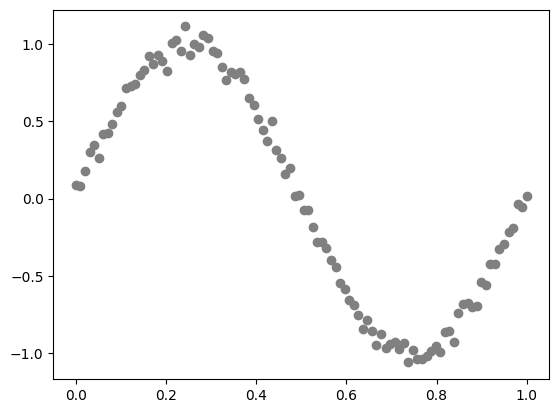

In [3]:
plt.scatter(x_values, y_values, label='Data with Noise', color='gray');


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
X_tensor = torch.tensor(x_values, dtype=torch.float32, device=device).unsqueeze(1)
y_tensor = torch.tensor(y_values, dtype=torch.float32, device=device).unsqueeze(1)

In [5]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.linear1 = nn.Linear(1, 10)
        self.gelu = nn.GELU()
        self.linear2 = nn.Linear(10, 10)
        self.selu = nn.SELU()
        self.linear3 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.linear2(x)
        x = self.selu(x)
        x = self.linear3(x)
        return x

model = RegressionModel()        


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
summary(model,(1,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              20
              GELU-2                   [-1, 10]               0
            Linear-3                   [-1, 10]             110
              SELU-4                   [-1, 10]               0
            Linear-5                    [-1, 1]              11
Total params: 141
Trainable params: 141
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [7]:
loss = nn.GaussianNLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    y_pred = model(X_tensor)
    var = torch.full((X_tensor.shape[0], 1), 0.0025, device=device, requires_grad=True)
    output = loss(y_pred, y_tensor, var)
    output.backward()
    optimizer.step()    

with torch.no_grad():
    y_pred = model(X_tensor)
    y_pred = y_pred.cpu().numpy().flatten()

In [8]:
# Define your true function
def true_function(x):
    return np.sin(2 * np.pi * x)

# Create data and Gaussian PDFs
x_values = np.linspace(0, 1, 100)
noise = np.random.normal(0, np.sqrt(0.0025), 100)
y_values = true_function(x_values) + noise

def animate(frame):
    # plt.clf()
    if frame == 0:
        plt.scatter(x_values,true_function(x_values), color='tab:blue')
    elif frame == 1:
        plt.scatter(x_values,true_function(x_values), color='tab:blue')
        plt.scatter(x_values, y_values, label='Data with Noise', color='tab:gray')
    elif frame == 2:
        plt.scatter(x_values,true_function(x_values), label='True Function',color='tab:blue')
        plt.scatter(x_values, y_values, color='gray')         
        plt.plot(x_values, y_pred, 'r', label='MLE Fit')
        plt.fill_between(x_values, y_pred - 2 * np.sqrt(0.0025), y_pred + 2 * np.sqrt(0.0025), color='r', alpha=0.3, label='95% Interval')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


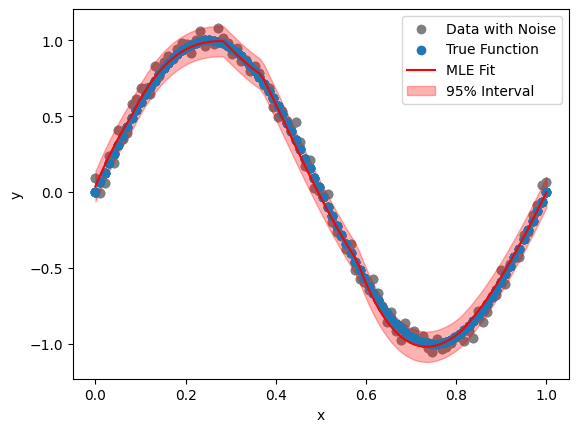

In [10]:
fig = plt.figure()
fig.set_facecolor('white')
anim = FuncAnimation(fig, animate, frames=3, interval=2000, repeat=True)
HTML(anim.to_jshtml())

In [11]:
loss1 = nn.GaussianNLLLoss()
optimizer1 = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer1.zero_grad()
    y_pred1 = model(X_tensor)
    var1 = torch.full((X_tensor.shape[0], 1), 300.0, device=device, requires_grad=True)
    output1 = loss1(y_pred1, y_tensor, var1)
    output1.backward()
    optimizer1.step()    

with torch.no_grad():
    y_pred1 = model(X_tensor)
    y_pred1 = y_pred1.cpu().numpy().flatten()

In [12]:
loss2 = nn.GaussianNLLLoss()
optimizer2 = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000
for epoch in range(num_epochs):
    optimizer2.zero_grad()
    y_pred2 = model(X_tensor)
    var2 = torch.full((X_tensor.shape[0], 1), .00000000025, device=device, requires_grad=True)
    output2 = loss2(y_pred2, y_tensor, var2)
    output2.backward()
    optimizer2.step()    

with torch.no_grad():
    y_pred2 = model(X_tensor)
    y_pred2 = y_pred2.cpu().numpy().flatten()

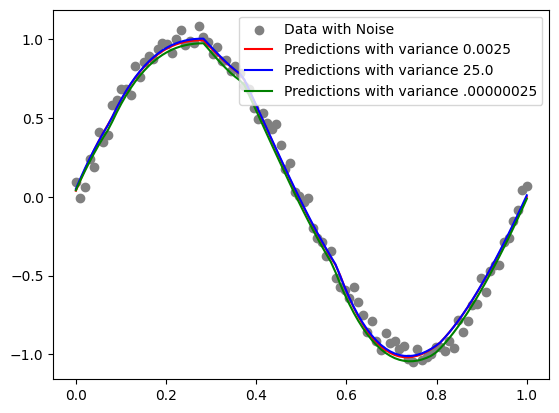

In [13]:
plt.scatter(x_values, y_values, label='Data with Noise', color='gray')
plt.plot(x_values, y_pred, label='Predictions with variance 0.0025', color='red')
plt.plot(x_values, y_pred1, label='Predictions with variance 25.0 ', color='blue')
plt.plot(x_values, y_pred2, label='Predictions with variance .00000025', color='green')
plt.legend()

2. [Total marks: 1.5] You toss a coin 10 times and the result turns out to be: [1, 0, 0, 1, 1, 0, 1, 0, 0, 0]. Find the MAP estimate for probability of heads if:
Prior is Beta distribution with parameters (alpha=2, beta=3):

    Calculate the answer analytically using the closed form MAP estimate [0.5 mark]

    Find the answer with gradient descent using torch.optim [0.5 mark]

    Prior is a Gaussian distribution with mean=0.5 and variance=0.1. Find the answer with gradient descent using torch.optim [0.5 mark]

Given data:
Number of heads $y_i = 4 $
Total no of tosses $(N)  = 10 $
$$
prior = p(\theta) = \frac{B(\alpha, \beta)}{\theta^{\alpha - 1} \cdot (1 - \theta)^{\beta - 1}}
$$
$\alpha = 2 , \beta = 3$

$$\theta_{\text{MAP}} = \arg\max_{\theta} P(\theta | D) = {P(D|\theta) \cdot P(\theta)}$$

$$\log P(\theta | D) = \sum_{i=0}^{N} \left( \log P(y_i|\theta) + \log P(\theta) \right)$$

$$\log P(\theta | D) = \sum_{i=0}^{N} \left( y_i\log\theta + (1 - y_i) \log(1-\theta) + (\alpha - 1)\log(\theta) + (\beta - 1)\log(1 - \theta) \right)$$

$$\frac{d}{d\theta} \left( \log P(\theta | D) \right) = \left( \frac{ \sum_{i=0}^{N}y_i}{\theta} - \frac{ \sum_{i=0}^{N}1 - y_i}{1 - \theta} + \frac{\alpha - 1}{\theta} - \frac{\beta - 1}{1 - \theta} \right) = 0$$

$$(1 - \theta) \sum_{i=0}^{N} y_i -  \theta \sum_{i=0}^{N} (1 - y_i)\ + (\alpha - 1) (1 - \theta) - (\beta - 1) \theta = 0
$$


$$\sum_{i=0}^{N} y_i + \alpha - 1 - \theta(N + \alpha +\beta -2) = 0$$

$$\theta_{\text{MAP}} = \frac{\sum_{i=0}^{N} y_i + \alpha - 1}{(N + \alpha +\beta -2)}$$

$$\theta_{\text{MAP}} = \frac{ 4 + 2 - 1}{(10 + 2 + 3 -2)}$$

